In [88]:
from glob import glob 
from pathlib import Path
import polars as pl
import re
import os

def extract_info_from_filename(filename):
    pattern = r"([a-zA-Z_]+)_cov_(0\.\d)_iden_(0\.\d)\.txt"
    match = re.match(pattern, filename)
    if match:
        category = match.group(1)
        coverage = float(match.group(2))
        identity = float(match.group(3))
        return category, coverage, identity
    return None

descriptors_dir = glob("database/descriptors/*")

dfs = {}

for path in descriptors_dir: 

    category = Path(path).stem
    dfs[category] = pl.read_parquet(path)


directory = './database/representatives' 


data = {}

for filename in os.listdir(directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(directory, filename)
        
        # Extract information from the filename
        info = extract_info_from_filename(filename)
        if info:
            category, coverage, identity = info
            
            # Read the file and collect ids
            with open(filepath) as f:
                ids = [line.strip() for line in f.readlines()]
            
            # Populate the nested dictionary
            if category not in data:
                data[category] = {}
            
            if coverage not in data[category]:
                data[category][coverage] = {}
            
            data[category][coverage][identity] = ids

result = []

for category, coverages in data.items():

    if category == "horizontal" or category == "peripheral": 
        continue
    
    for coverage, identities in coverages.items():
            
        for identity, ids in identities.items():

            if coverage == 0.7 and identity == 0.3: 

                buff_df = (dfs[category]
                            .filter(pl.col("id").is_in(ids))
                            .with_columns(
                                category = pl.lit(category)
                            )
                        ).sample(n=600, with_replacement=False)
                
                result.append(buff_df)
                
final_data = pl.concat(result, how = "vertical")
                


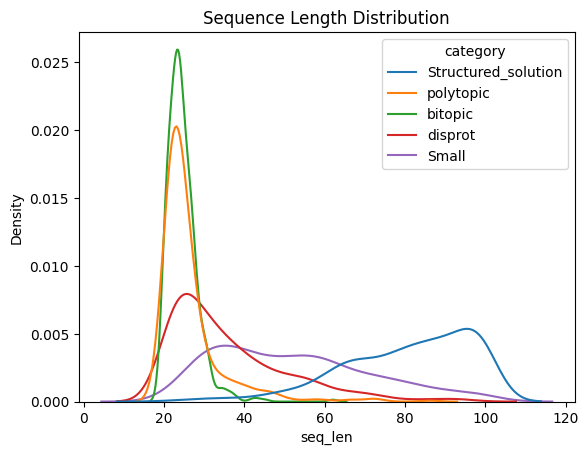

In [84]:
import matplotlib.pyplot as plt 
import seaborn as sns   

plt.figure()
sns.kdeplot(data = final_data.filter(~pl.col("category").is_in(["random_uniform","random_proportional"])), x = "seq_len", hue = "category", fill = False)
plt.title("Sequence Length Distribution")
plt.show()


In [39]:
final_data.filter(pl.col("category") == "polytopic").select(pl.col("id")).write_csv("representatives.csv")

{'20-29': (np.float64(0.2298057), np.float64(0.298717966), np.float64(0.753683153), np.float64(1.0)), '30-39': (np.float64(0.40664549314285714), np.float64(0.5372642125714286), np.float64(0.9335202597142858), np.float64(1.0)), '40-49': (np.float64(0.6023927404285715), np.float64(0.7309277984285715), np.float64(0.9995954861428571), np.float64(1.0)), '50-59': (np.float64(0.7880554397142857), np.float64(0.8453623525714286), np.float64(0.9389048254285713), np.float64(1.0)), '60-69': (np.float64(0.9299392858571429), np.float64(0.8198256137142858), np.float64(0.7608592359999999), np.float64(1.0)), '70-79': (np.float64(0.9672601712857143), np.float64(0.6566848025714287), np.float64(0.5372797171428574), np.float64(1.0)), '80-89': (np.float64(0.8862493181428571), np.float64(0.41331102057142854), np.float64(0.32481713285714287), np.float64(1.0)), '90-99': (np.float64(0.705673158), np.float64(0.01555616), np.float64(0.150232812), np.float64(1.0))}


/var/folders/rn/p_r48y552n32kyd53pxnth_80000gn/T/ipykernel_2673/2046664444.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm', len(length_labels))


KeyError: 'color'

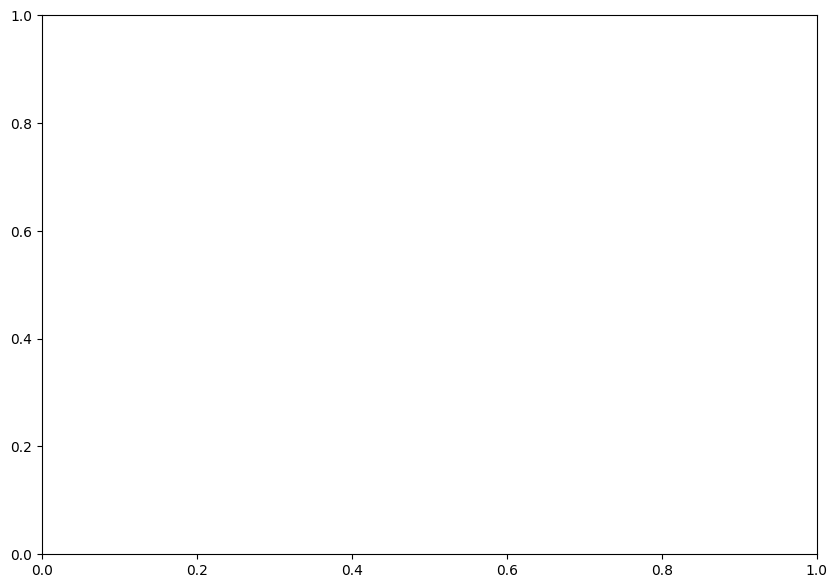

In [91]:
import polars as pl
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse

sequence_descriptors = [
    
    'hydrophobic_portion', 'iupred_portion', 'iupred_mean', 'anchor_portion', 
    'HCA_score', 'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 
    'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'ARGP820103', 'BHAR880101', 'CHAM810101', 
    'CHAM820101', 'CHAM830101', 'CHAM830107', 'CHAM830108', 'CHOP780201', 'CHOP780202', 
    'CHOP780203', 'CIDH920105', 'FASG760101', 'FAUJ880102', 'FAUJ880103', 'FAUJ880104', 
    'FAUJ880105', 'FAUJ880106', 'FAUJ880109', 'FAUJ880110', 'FAUJ880111', 'FAUJ880112', 
    'FAUJ880113', 'GRAR740102', 'JANJ780102', 'JANJ780103', 'JOND920102', 'JUNJ780101', 
    'KLEP840101', 'KRIW790101', 'KYTJ820101', 'LEVM760102', 'LEVM760103', 'LEVM760104', 
    'LEVM760105', 'LEVM760106', 'LEVM760107', 'NISK800101', 'NISK860101', 'PONP800101', 
    'RACS770103', 'RADA880108', 'ROSG850101', 'ROSG850102', 'ROSM880102', 'WARP780101', 
    'WOLR810101', 'VINM940101', 'TAKK010101', 'MONM990201', 'KOEP990101', 'KOEP990102', 
    'MITS020101', 'COSI940101', 'PONP930101', 'ZHOH040102', 'ZHOH040103', 'BAEK050101', 
    'CASG920101'

]

category_to_choose = ["polytopic","bitopic","disprot","Small","Structured_solution"]

df = final_data.select(pl.exclude(sequence_descriptors)).filter(pl.col("category").is_in(category_to_choose))

# Convert Polars DataFrame to Pandas for PCA
df_pd = df.to_pandas()

# Selecting only numeric columns
numeric_columns = df_pd.select_dtypes(include=[np.number]).columns
X = df_pd[numeric_columns].values

# Extract categories
categories = df_pd['category']
ids = df_pd['id']  
lengths = df_pd['seq_len']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pl.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'category': categories,
    'id': ids,
    'seq_len' : lengths
})

pca_df_pd = pca_df.to_pandas()

min_length = pca_df_pd['seq_len'].min()
max_length = pca_df_pd['seq_len'].max()

bin_width = 10

length_bins = list(range(int(min_length), int(max_length) + bin_width, bin_width))
length_labels = [f'{length_bins[i]}-{length_bins[i+1]-1}' for i in range(len(length_bins) - 1)]

pca_df_pd['length'] = pd.cut(pca_df_pd['seq_len'], bins=length_bins, labels=length_labels, include_lowest=True)

# Length colormap
cmap = plt.cm.get_cmap('coolwarm', len(length_labels))
length_color_map = {label: cmap(i) for i, label in enumerate(length_labels)}
print(length_color_map)


palette = sns.color_palette('Set1', n_colors=len(pca_df_pd['category'].unique()))

category_colors = dict(zip(pca_df_pd['category'].unique(), palette))


def draw_ellipse(ax, x_data, y_data, color):

    cov = np.cov(x_data, y_data)
    mean = [np.mean(x_data), np.mean(y_data)]
    
    # Eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    # Calculate angle and width/height of ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals)
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                      edgecolor=color, fc='None', lw=2)
    ax.add_patch(ellipse)

plt.figure(figsize=(10, 7))
ax = plt.gca()
#ax = sns.scatterplot(x='PC1', y='PC2', hue='length', data=pca_df_pd, palette='Set2', s=20)
sc = ax.scatter(pca_df_pd['PC1'], pca_df_pd['PC2'], c=pca_df_pd['color'], s=20)

norm = plt.Normalize(vmin=min_length, vmax=max_length)
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])

plt.colorbar(sm, ax=ax, label='Sequence Length')


"""
for category in pca_df_pd['category'].unique():

    subset = pca_df_pd[pca_df_pd['category'] == category]

    draw_ellipse(ax, subset['PC1'], subset['PC2'], color=category_colors[category])
"""

plt.title('Linear PCA for pTrans embeddings. cov 0.7 iden 0.3 length > 30')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

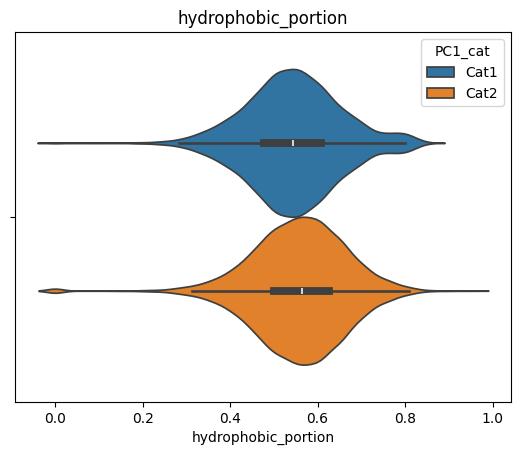

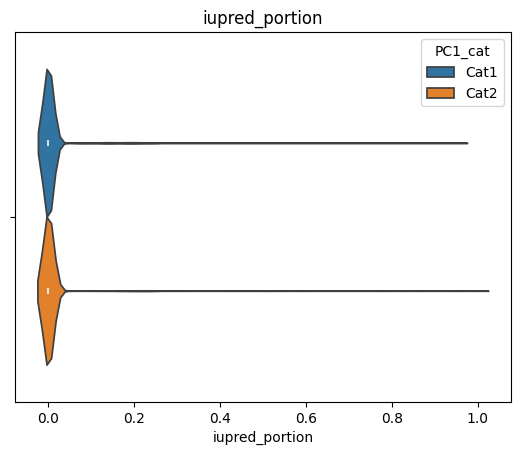

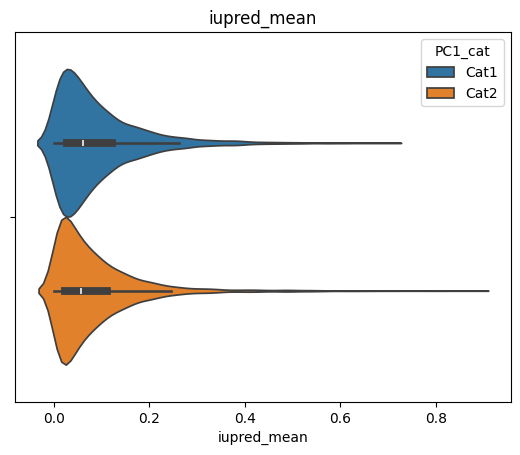

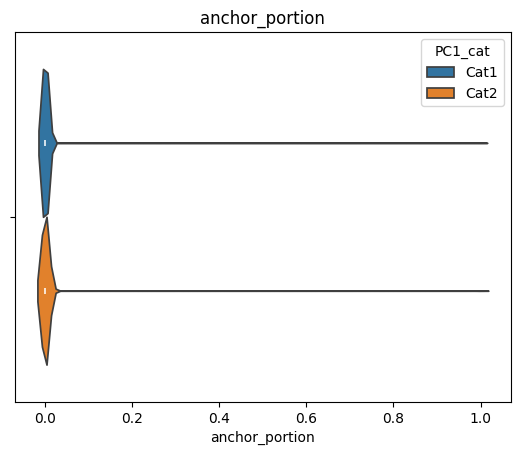

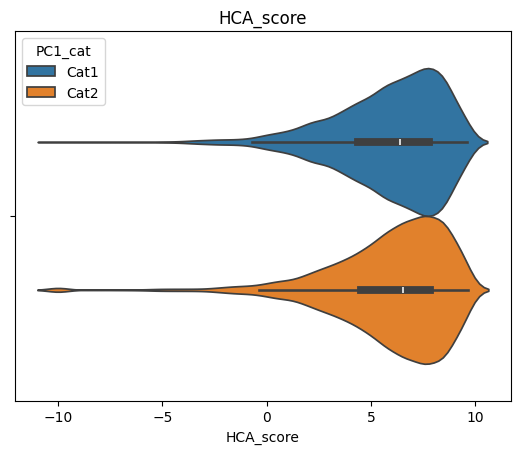

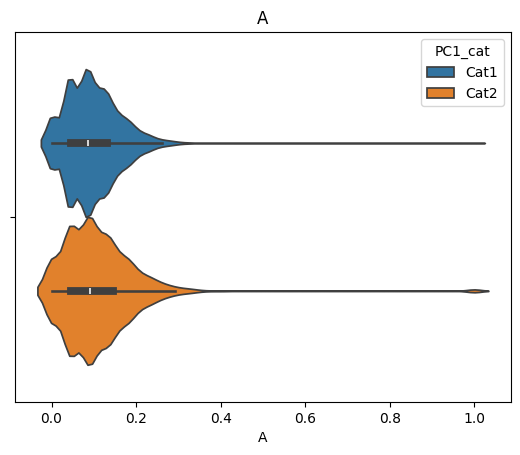

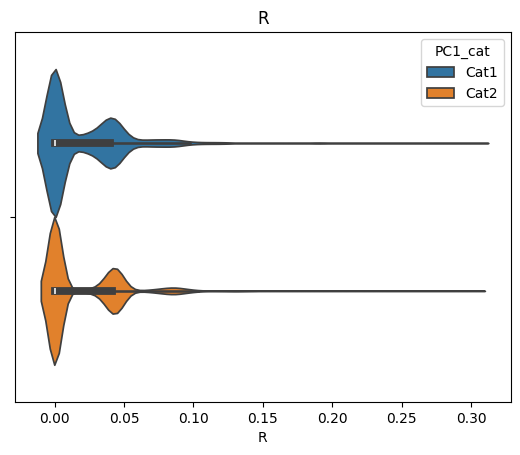

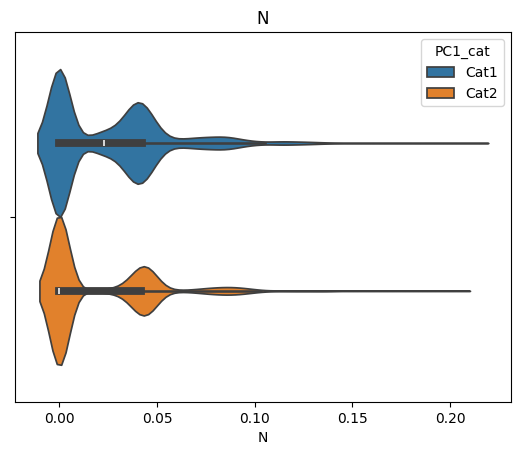

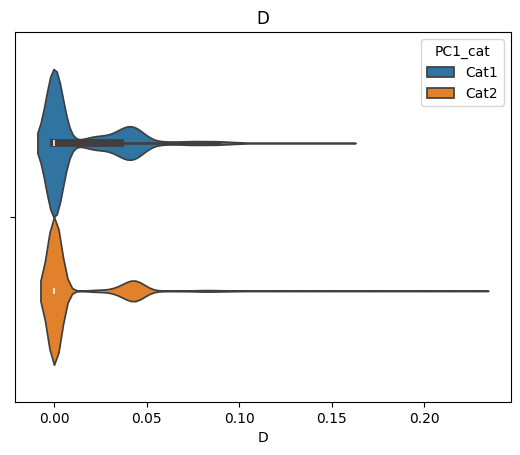

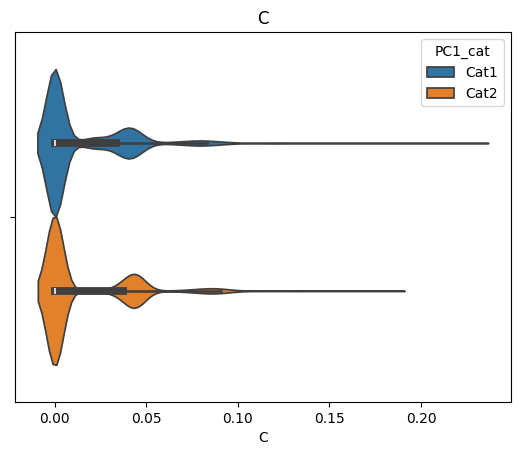

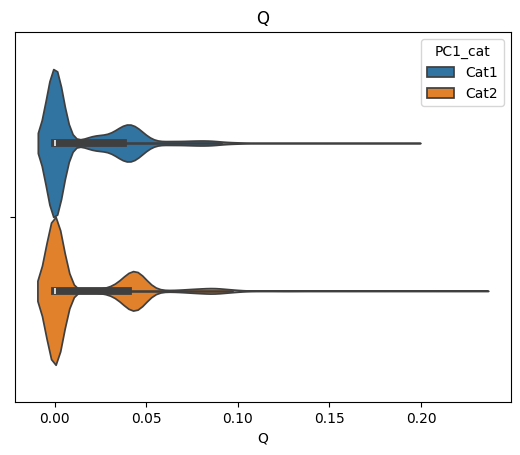

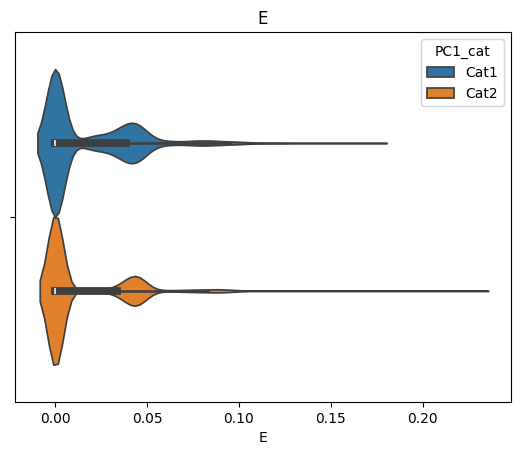

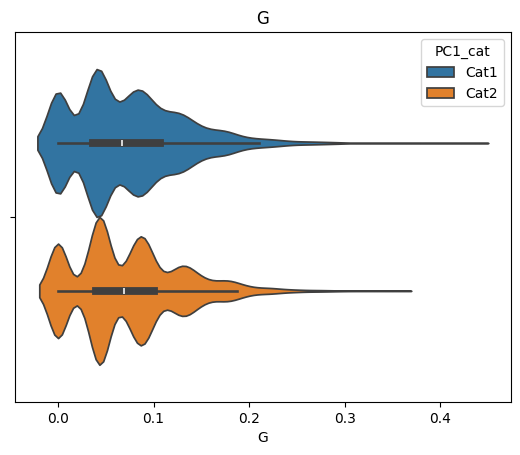

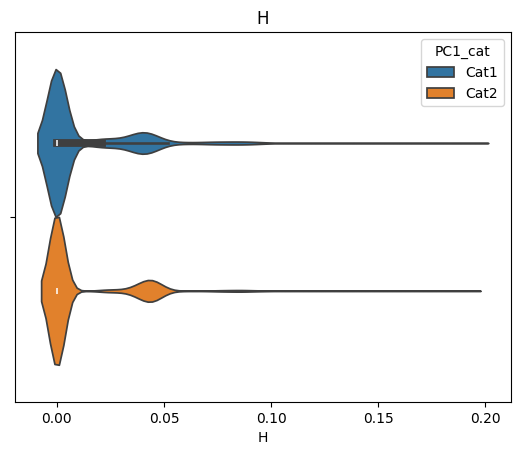

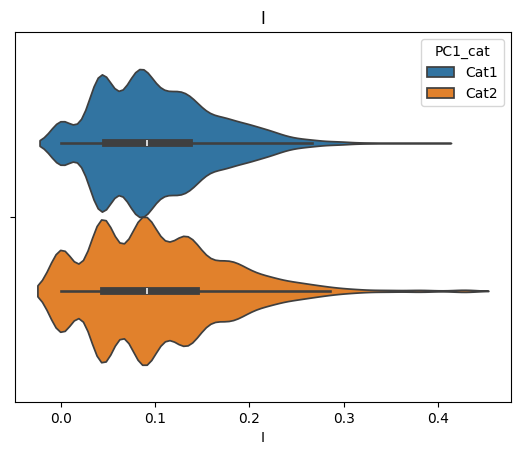

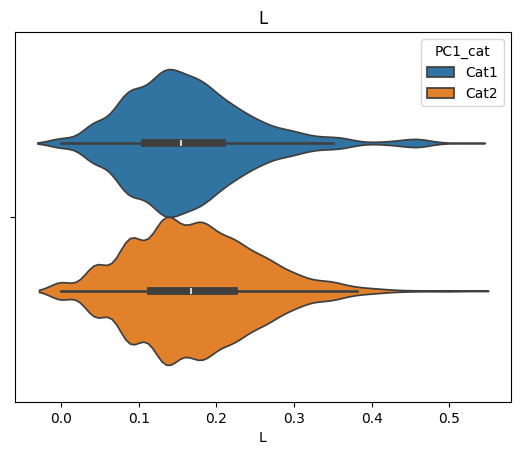

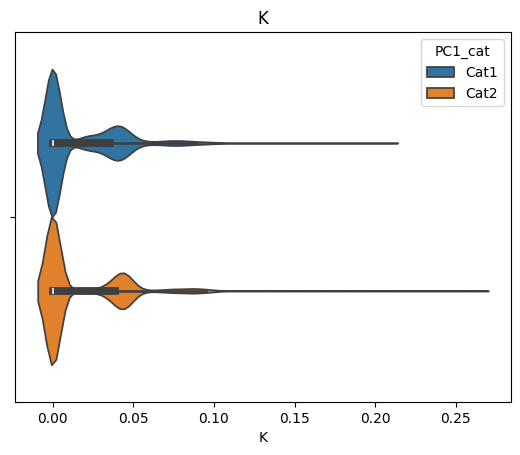

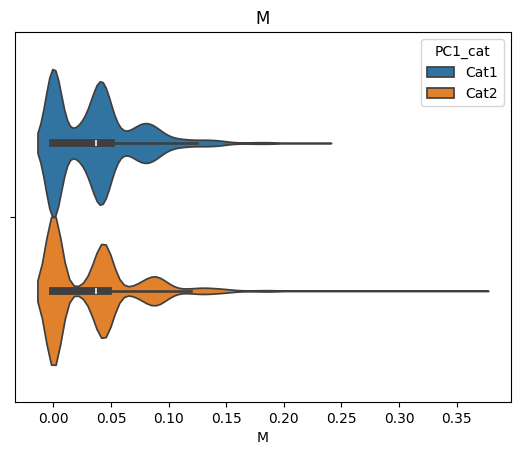

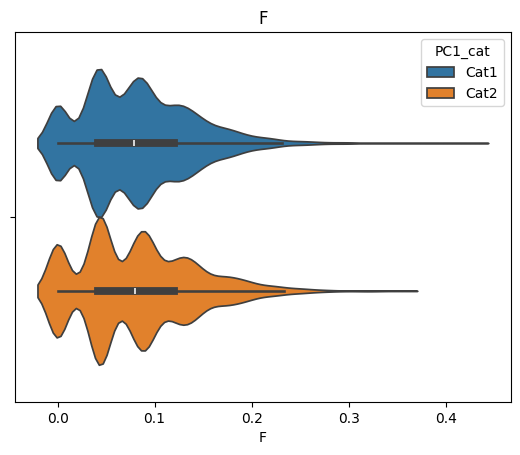

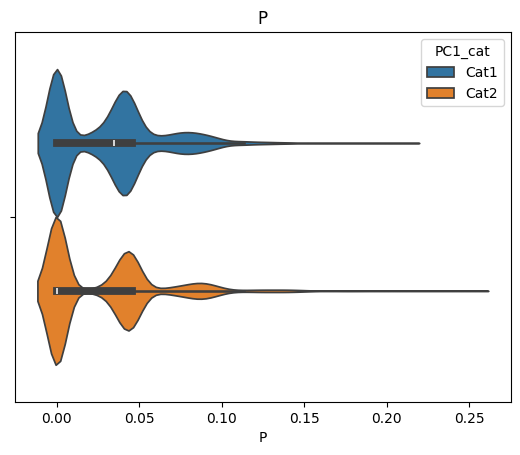

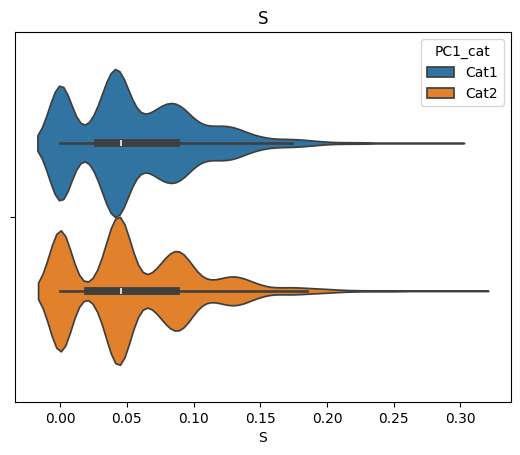

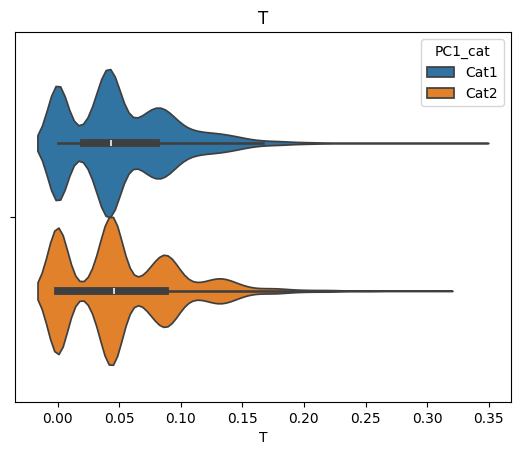

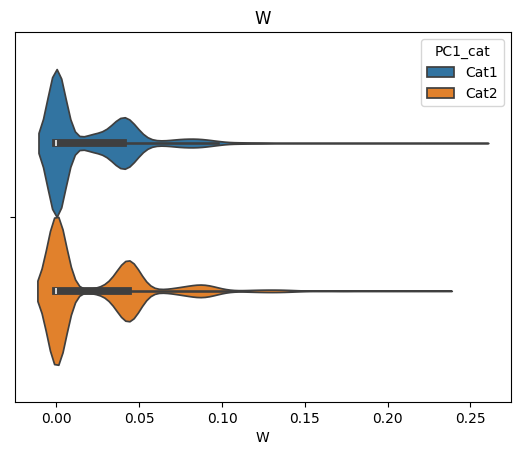

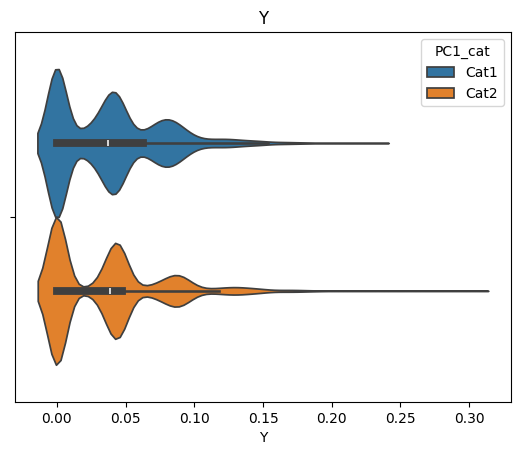

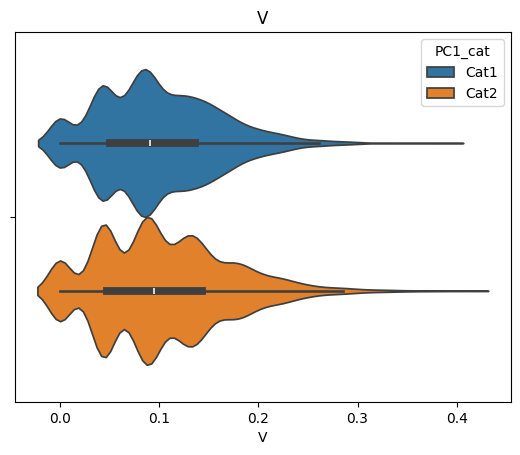

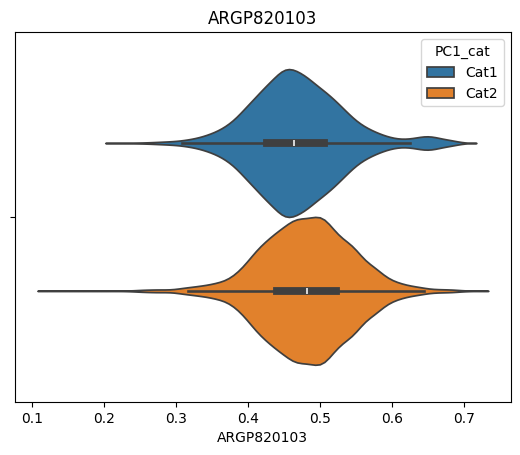

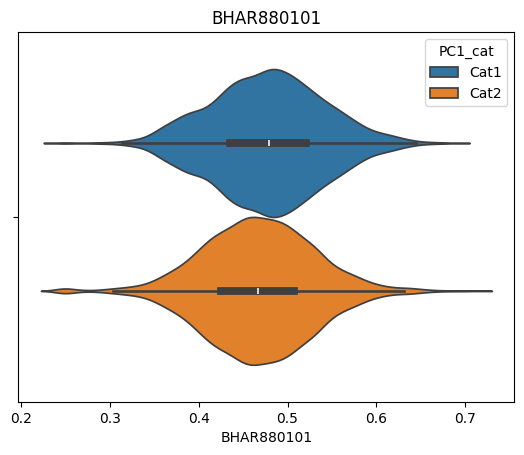

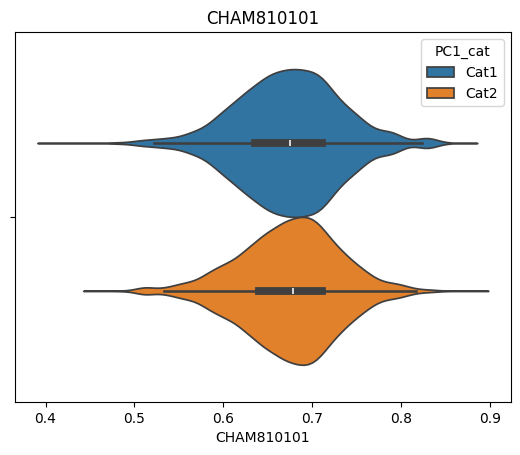

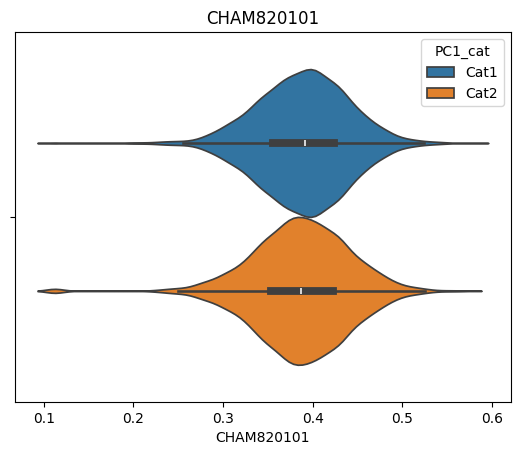

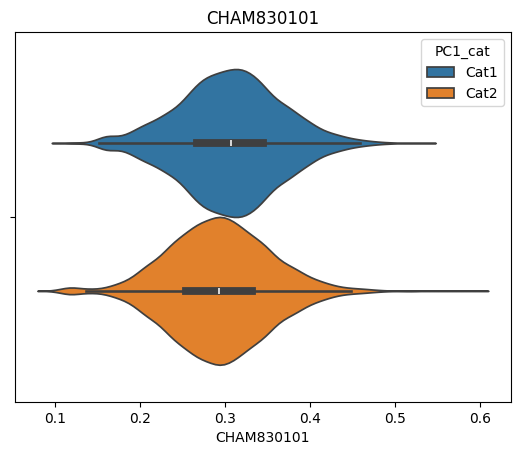

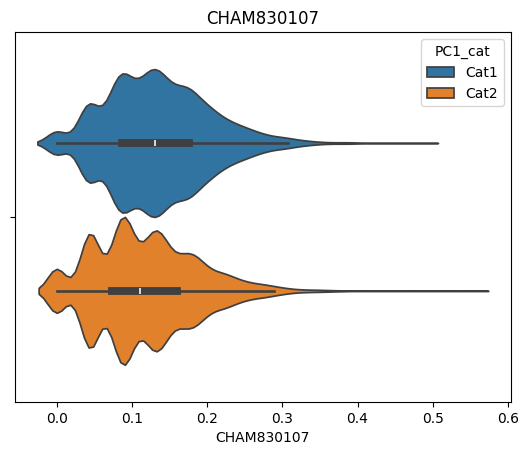

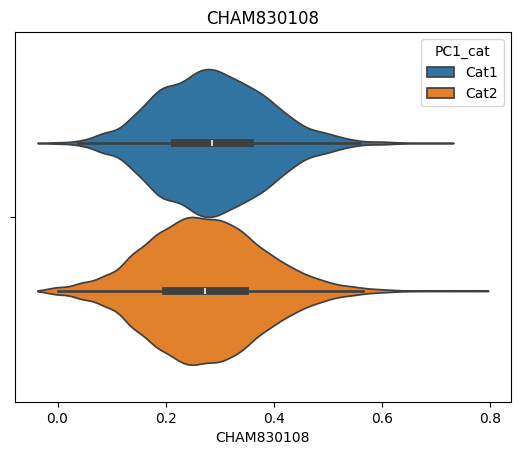

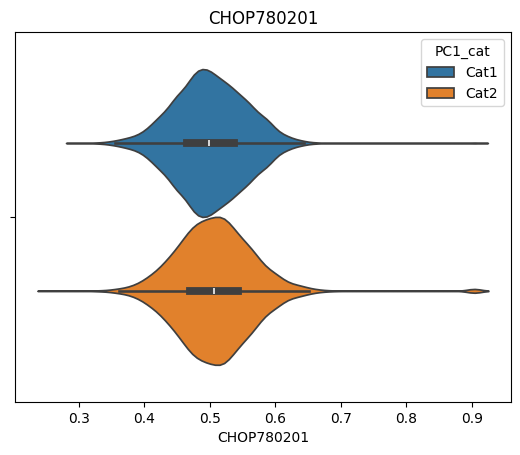

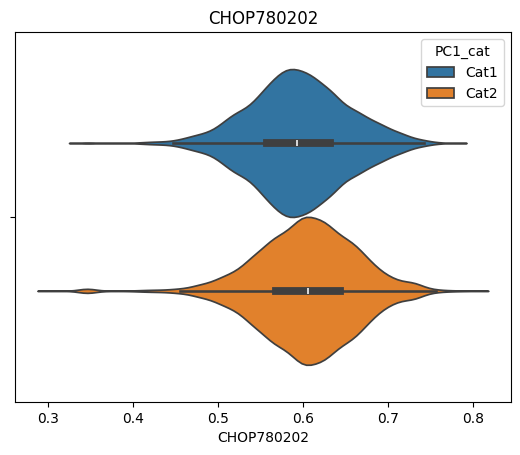

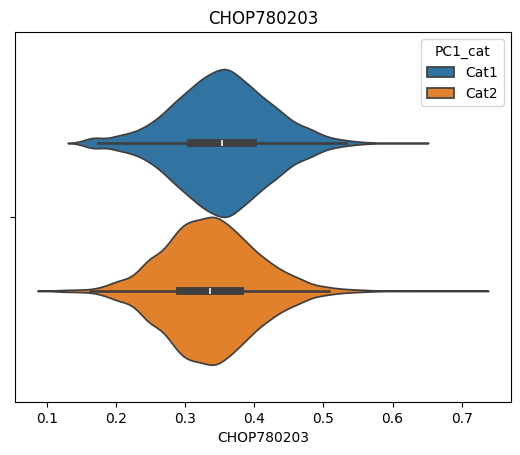

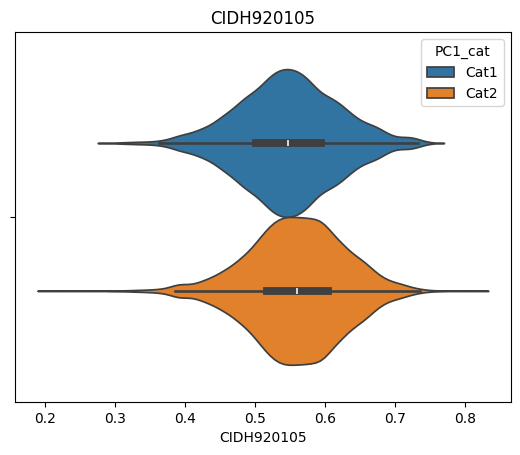

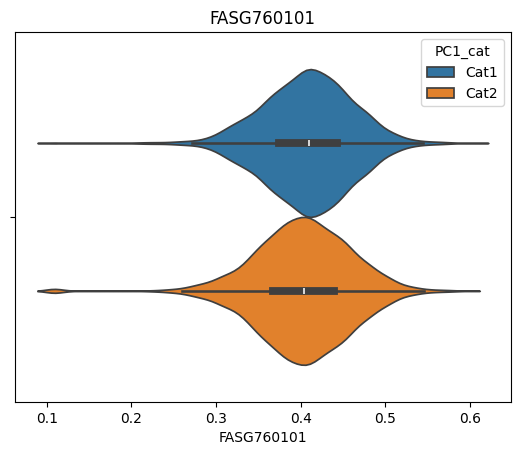

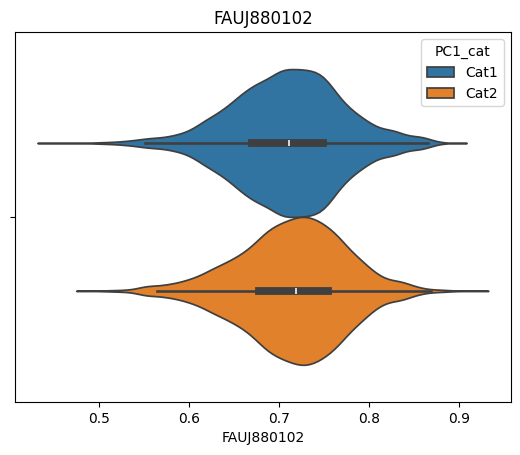

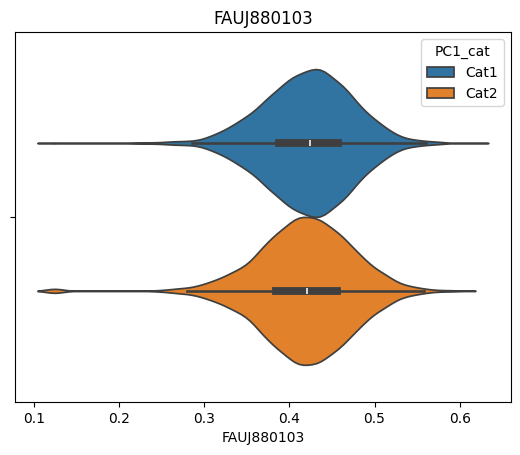

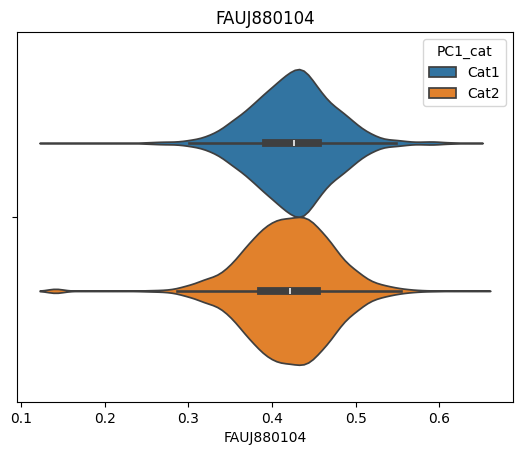

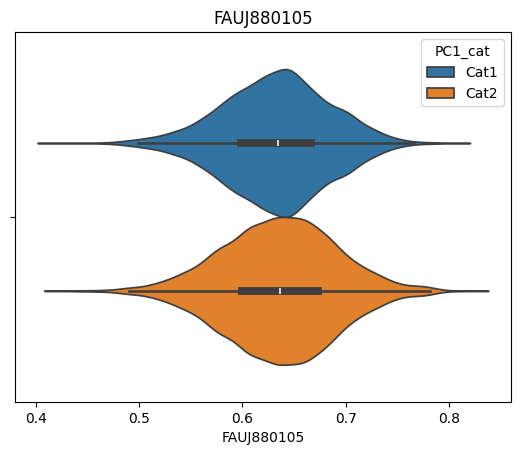

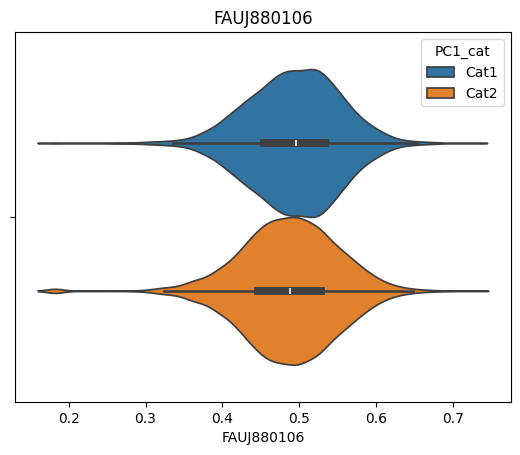

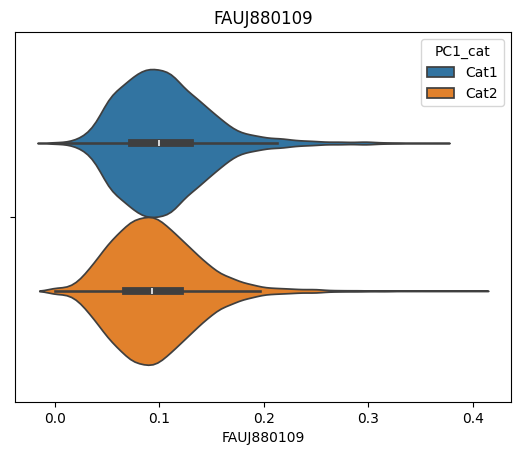

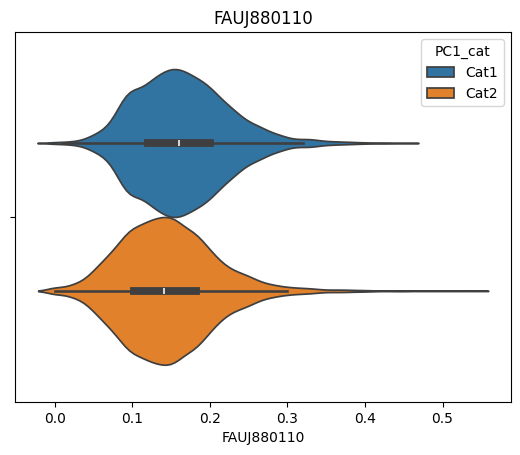

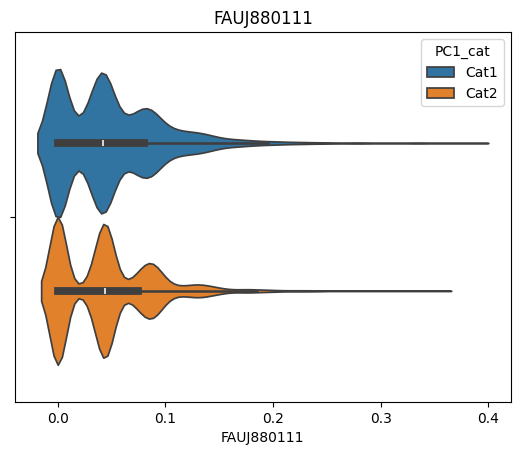

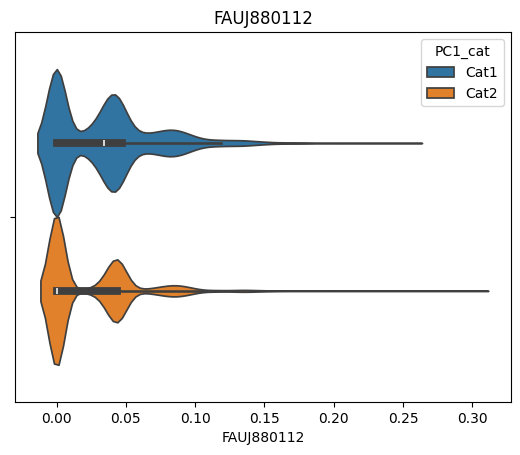

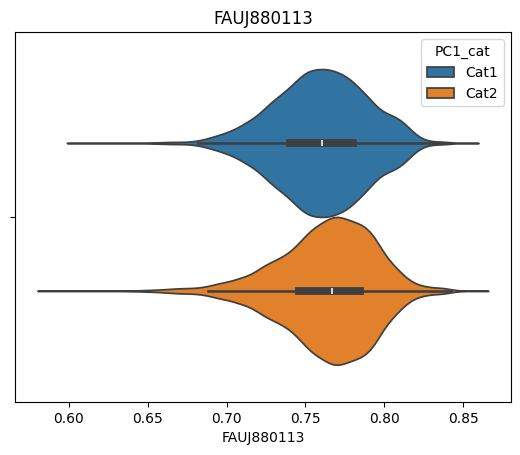

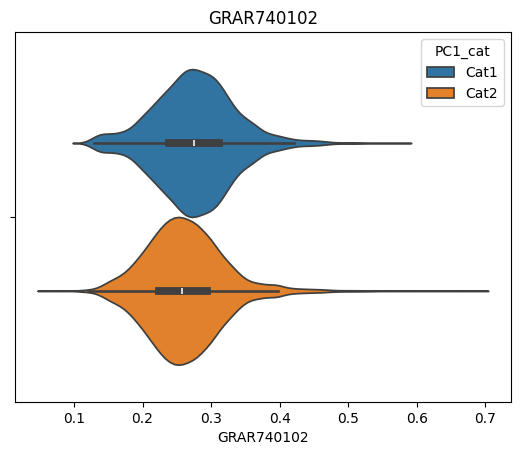

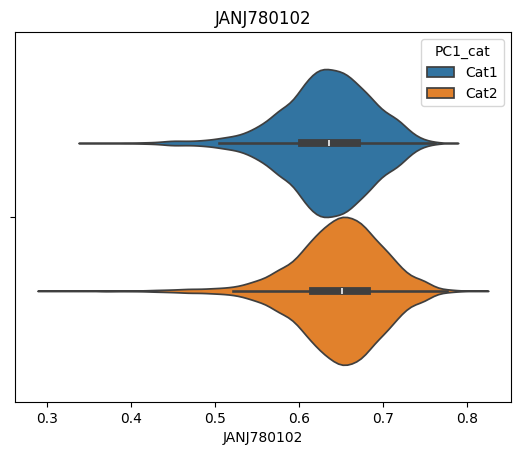

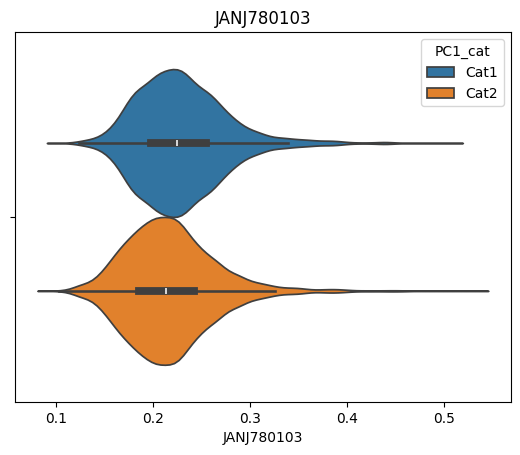

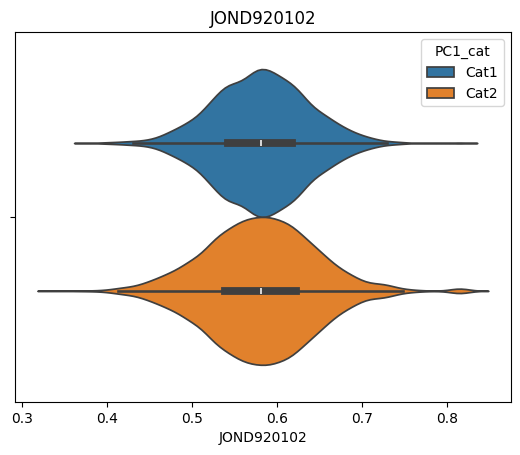

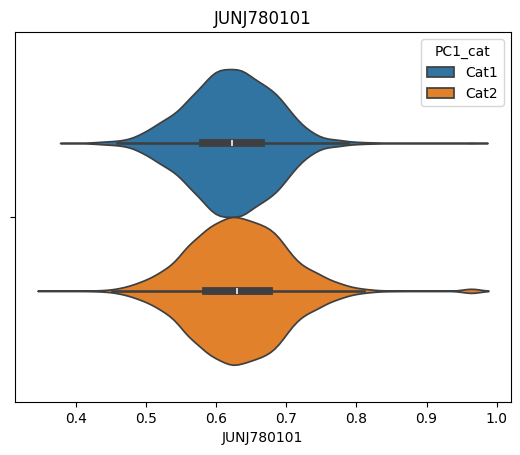

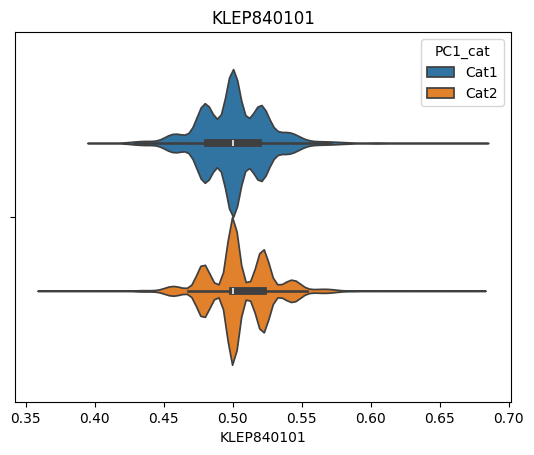

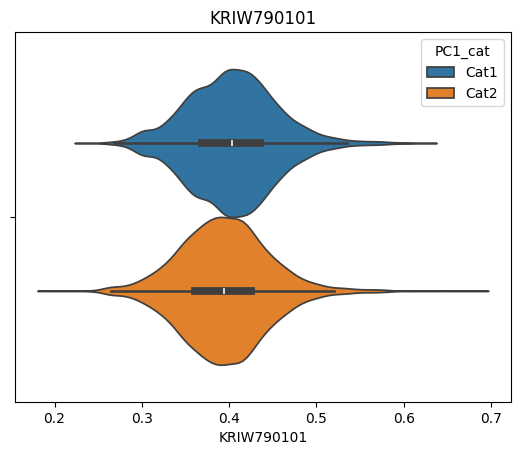

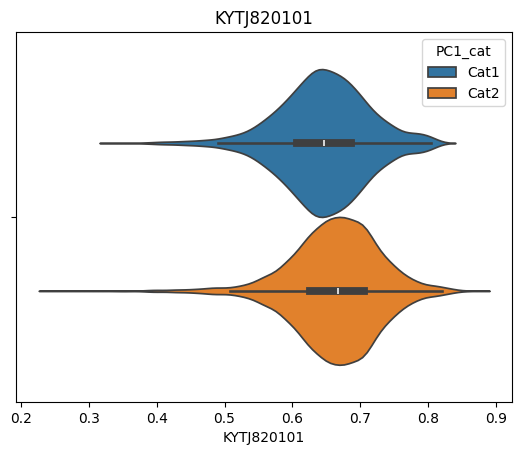

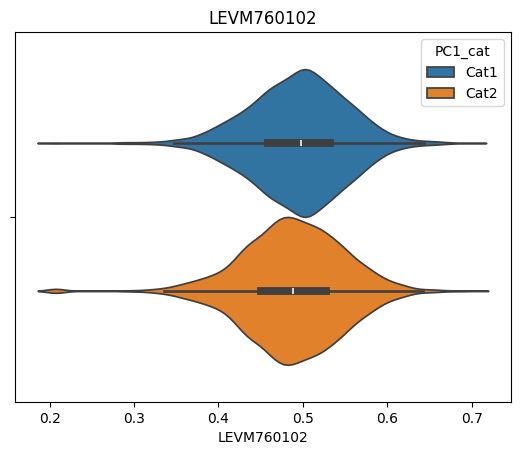

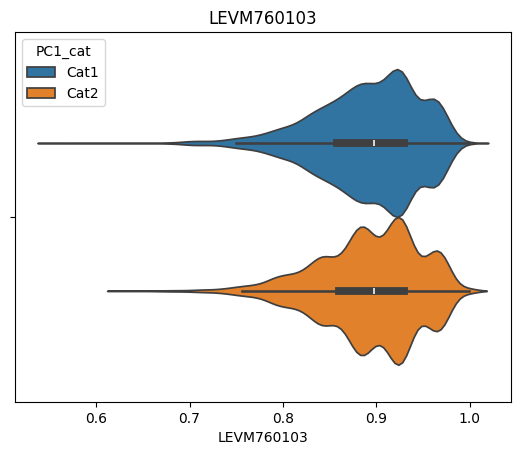

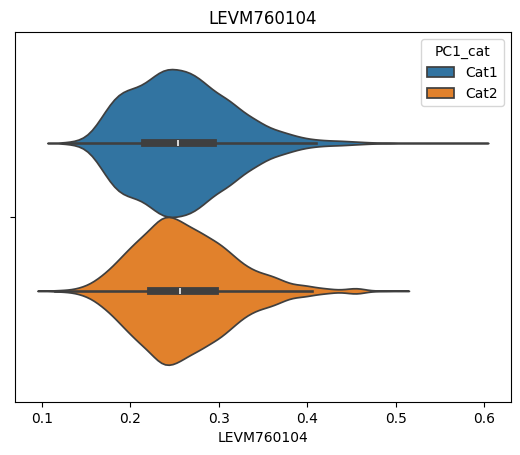

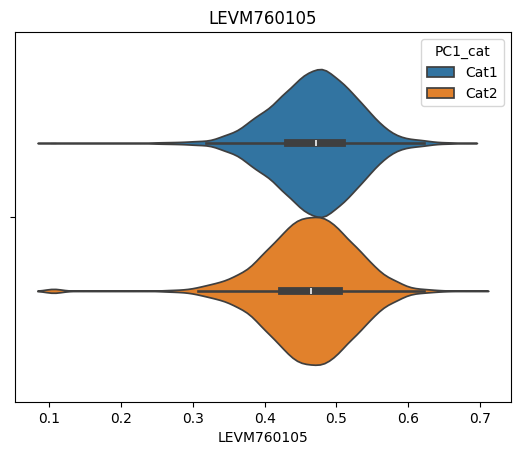

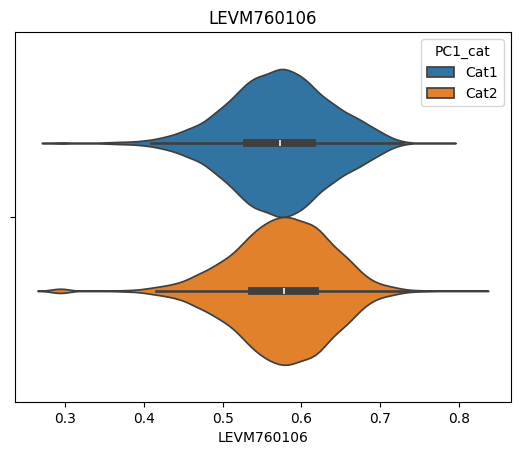

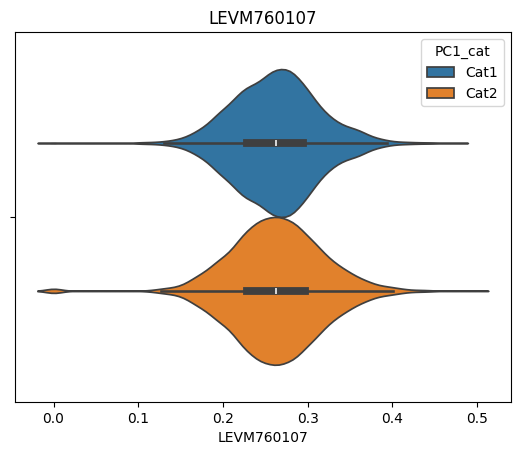

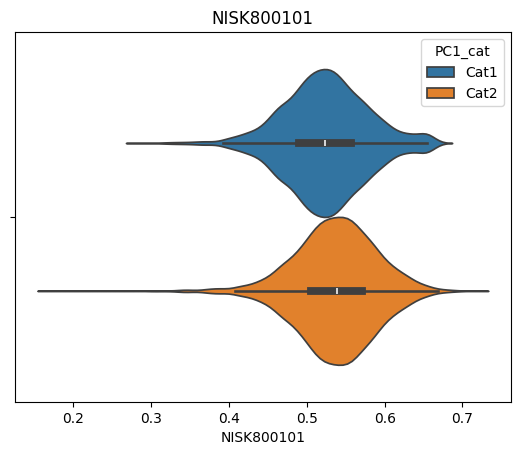

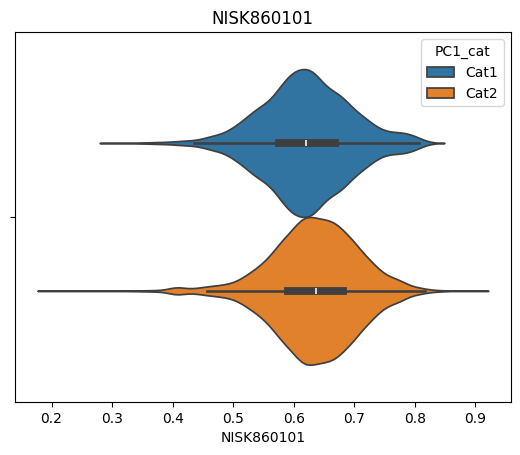

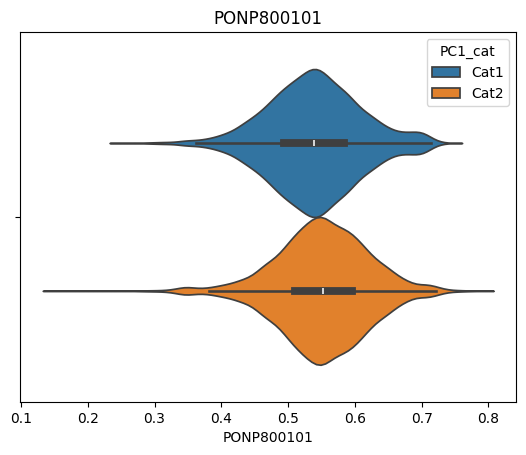

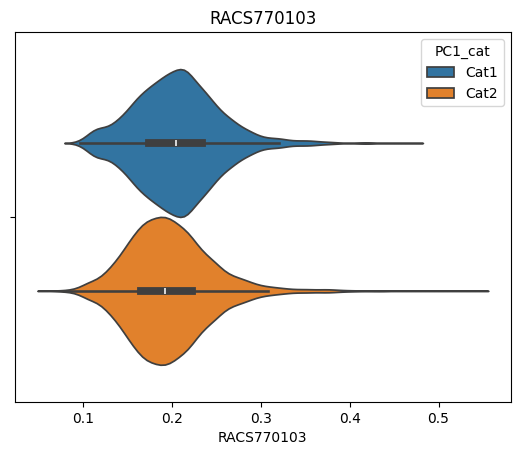

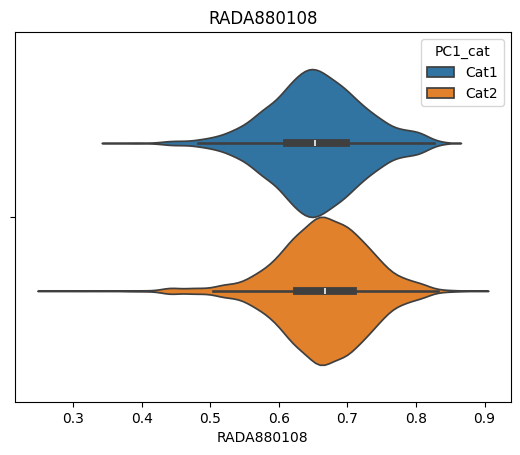

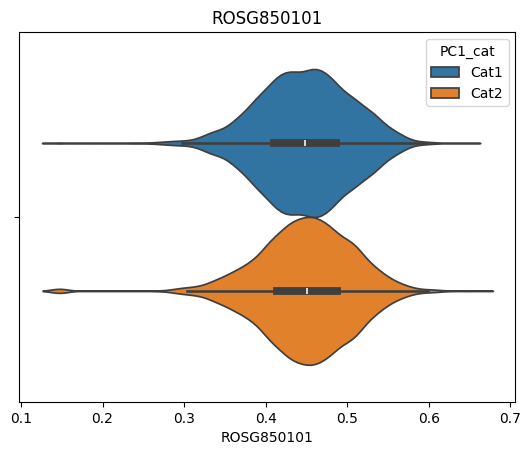

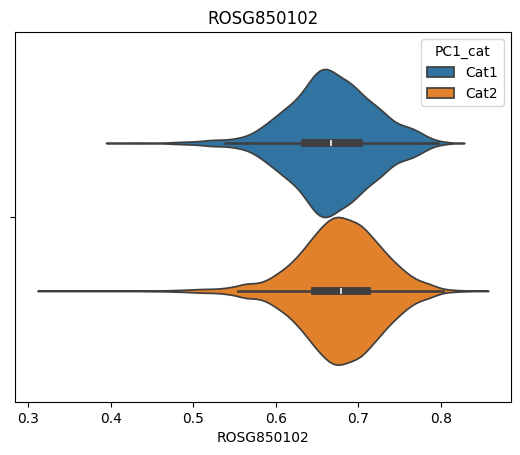

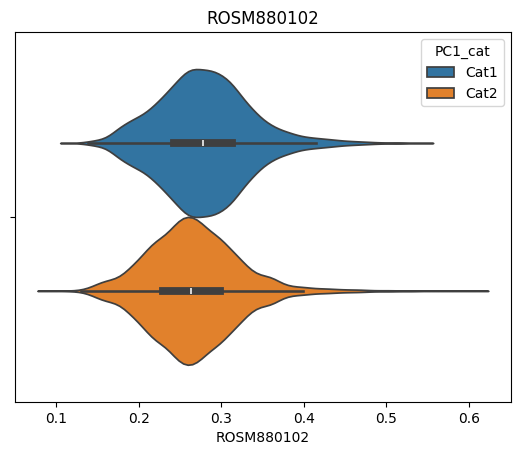

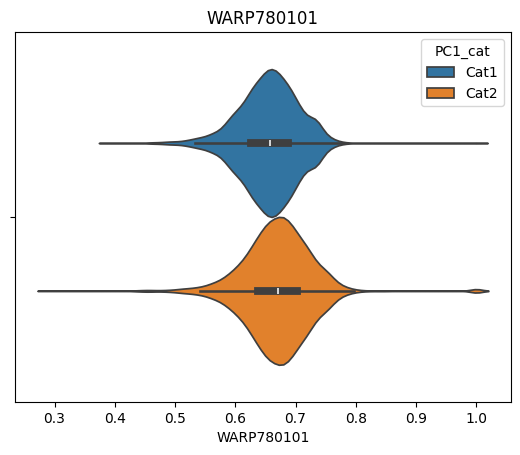

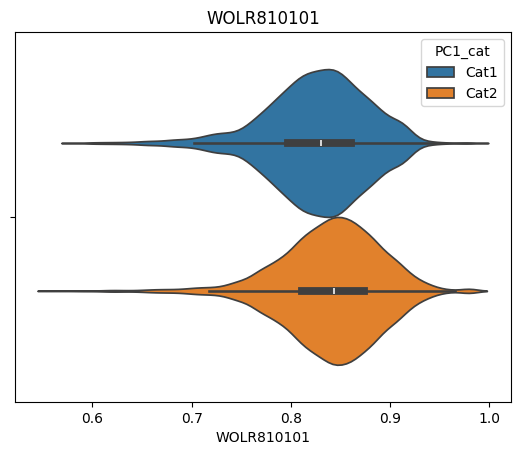

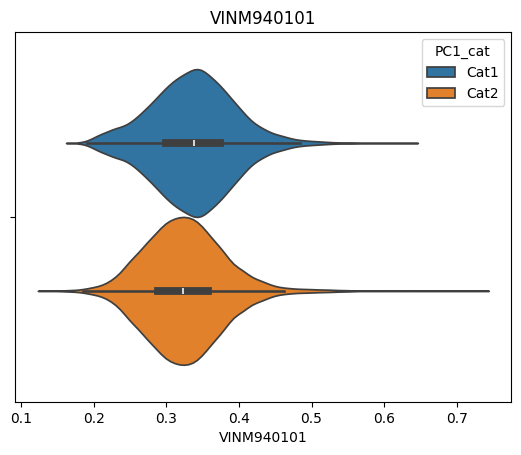

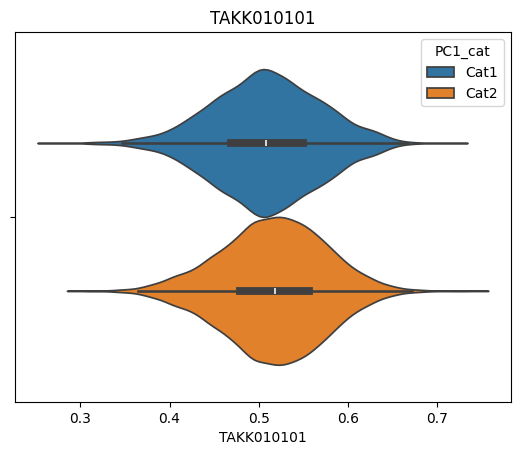

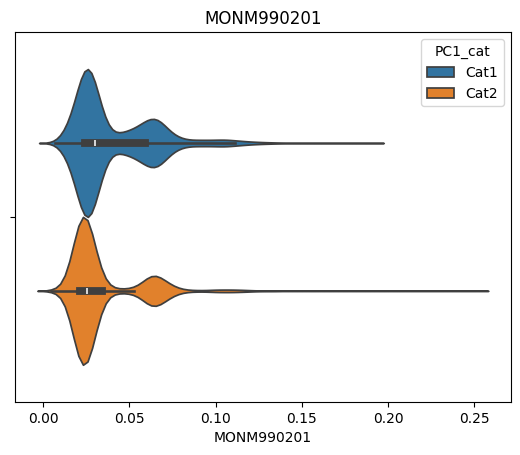

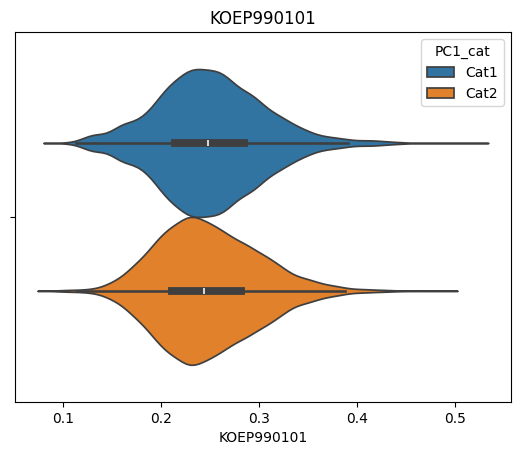

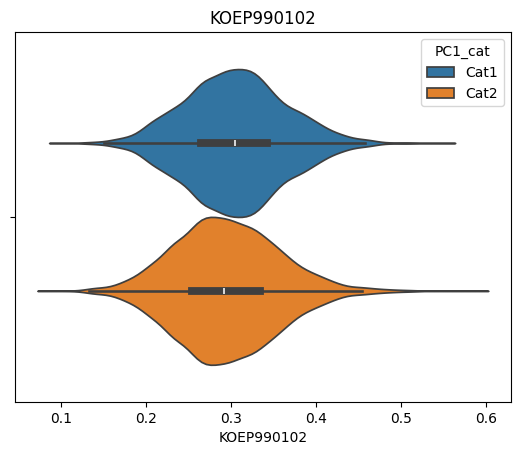

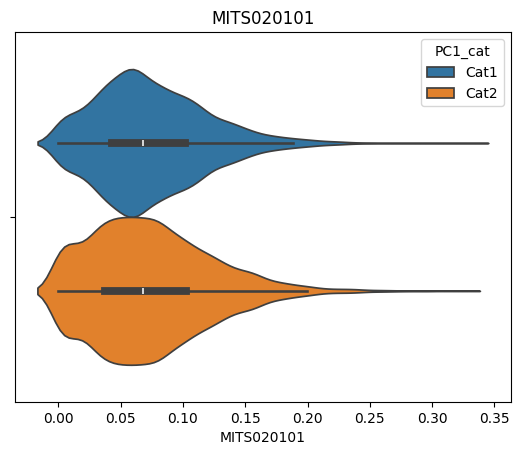

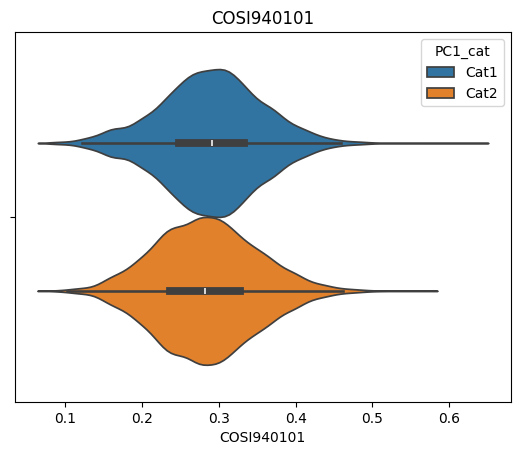

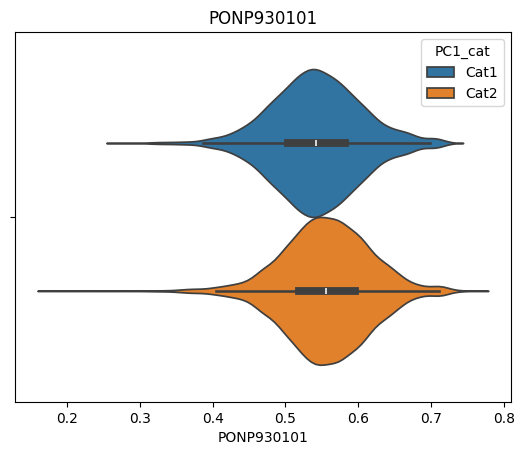

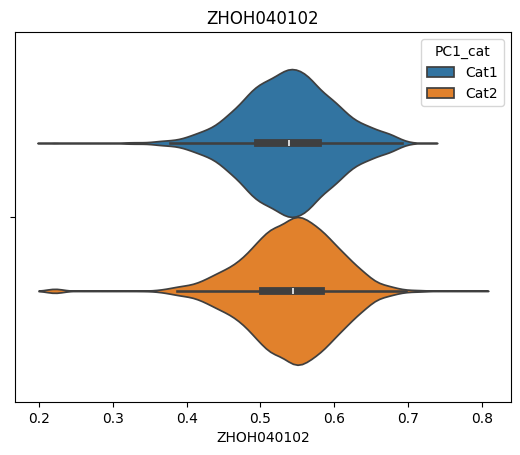

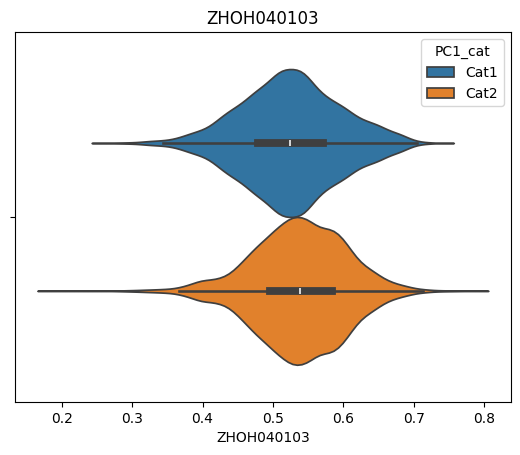

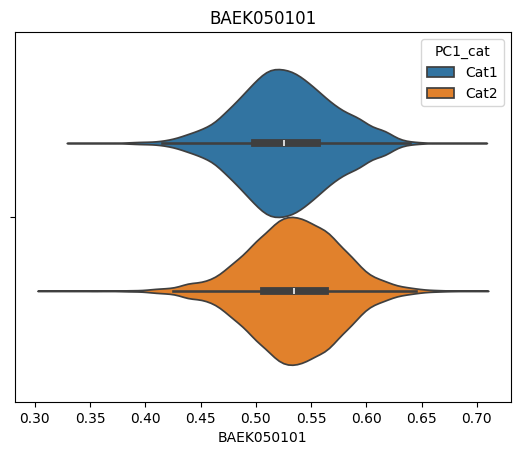

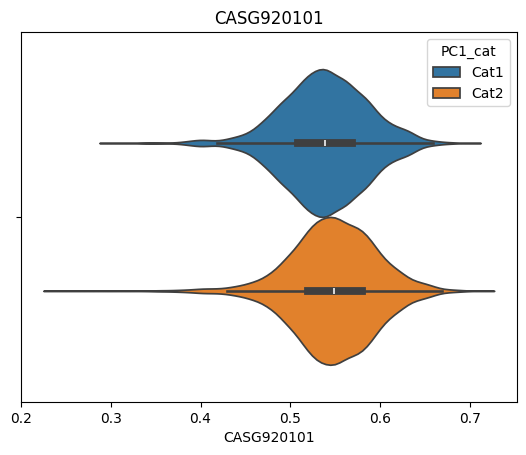

In [72]:
pca_df = pca_df.with_columns(

    pl.when(pl.col("PC1") >= 3)
    .then(pl.lit("Cat1"))  
    .otherwise(pl.lit("Cat2"))  
    .alias("PC1_cat")  
    
)

df = pca_df.join(final_data, on = "id", how = "inner")

from scipy.stats import wilcoxon


for descriptor in sequence_descriptors: 

    plt.figure()
    sns.violinplot(data = df, x = descriptor, hue = "PC1_cat")
    plt.title(descriptor)
    
    # Add t test for each descriptor
    cat1 = df.filter(pl.col("PC1_cat") == "Cat1").select(descriptor)
    cat2 = df.filter(pl.col("PC1_cat") == "Cat2").select(descriptor)

    #print(cat1.to_numpy())

    #res = wilcoxon(list(cat1.to_numpy()), list(cat2.to_numpy()), alternative = "greater")

    #plt.text(0.5, 0.5, f"p-value: {p_val}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)    

    plt.show()

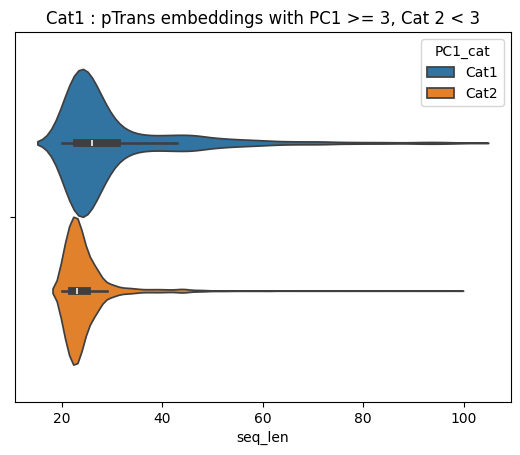

4538 6574


In [74]:
plt.figure()
sns.violinplot(data = df, x = "seq_len", hue = "PC1_cat")
plt.title("Cat1 : pTrans embeddings with PC1 >= 3, Cat 2 < 3")
plt.show()

# t test for sequence length between the two categories

from scipy.stats import ttest_ind

cat1 = df.filter(pl.col("PC1_cat") == "Cat1").select("seq_len").to_pandas()
cat2 = df.filter(pl.col("PC1_cat") == "Cat2").select("seq_len").to_pandas()

print(len(cat1), len(cat2))
